In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from itertools import count
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Run interactively

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from runner import Runner

In [4]:
run = Runner("wildstyle", "~/.local/src/celeritas/build-opt")

In [5]:
result = run(2**12)
print("Completed", result['run']['num_tracks'], "tracks in", result['result']['total_time'], "seconds")

Completed 4096 tracks in 0.00621022 seconds


In [6]:
sum(result['result']['alive'])

234519

## Analyze

In [7]:
from pathlib import Path

def load_one(dirname):
    with open(Path(dirname) / 'results.json', 'r') as f:
        results = json.load(f)
    kernels = results['final_result']['runtime']['kernels']
    for k in ['iterate', 'interact']:
        try:
            stats = kernels[k]
        except KeyError:
            continue
        else:
            break
    else:
        stats = {}
            
    slc = slice(None, None, None)

    return {
        'tracks': np.array(results['num_tracks'])[slc],
        'time': np.array(results['time'])[slc],
        'sum_steps': np.array(results['steps'])[slc],
        'max_steps': len(results['final_result']['result']['alive']),
        'stats': stats,
    }

In [90]:
labels = {
    'd7c4168': 'Original',
    'b73a69d': 'Remove grid striding',
    '9c9a20f': 'Local memory for pos/dir/time',
    '5aca14b': 'Local memory for RNG',
    'f9ed81d': 'Struct of arrays for particle energy/id',
    '781007f': 'Preallocate one secondary per interaction',
    '2ccd69e': 'Split into move/interact kernels',
    'b334510': 'Use 32-bit int for stack allocator size',
    '489992c': 'Combine all changes',
}

In [91]:
results = {k: load_one(k) for k in labels}

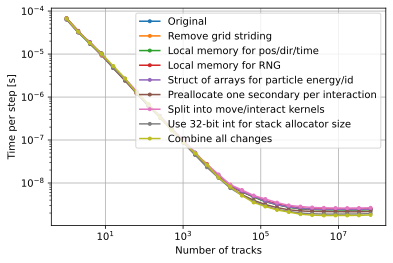

In [92]:
(fig, ax) = plt.subplots(subplot_kw=dict(xscale='log', yscale='log'))
for k in labels:
    r = results[k]
    ax.plot(r['tracks'], r['time'] / r['sum_steps'], marker='.', label=labels[k])
ax.grid()

ax.set_xlabel("Number of tracks")
ax.set_ylabel("Time per step [s]")
ax.legend();

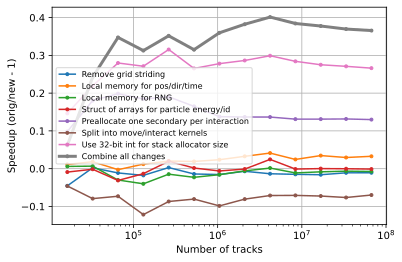

In [93]:
(fig, ax) = plt.subplots(subplot_kw=dict(xscale='log'))
changes_k = list(labels)
ref_k = changes_k.pop(0)
combo_k = changes_k.pop(-1)
ref_tracks = results[ref_k]['tracks']
slc = ref_tracks > 1e4
ref_tracks = ref_tracks[slc]
ref_time = results[ref_k]['time'][slc]

def _plot(k, **kwargs):
    r = results[k]
    ax.plot(ref_tracks, ref_time / r['time'][slc] - 1, marker='.', label=labels[k], **kwargs)

for k in changes_k:
    _plot(k)
_plot(combo_k, color='gray', linewidth=3)
ax.grid()
ax.set_xlabel("Number of tracks")
ax.set_ylabel("Speedup (orig/new - 1)")
ax.legend(loc='center left', fontsize=8);
fig.savefig('speedups.pdf')

In [101]:
slc = results[ref_k]['tracks'] > 1e6
ref_time = results[ref_k]['time'][slc]
for k in changes_k + [combo_k]:
    speedup = ref_time / results[k]['time'][slc] - 1
    mean = np.mean(speedup)
    stdev = np.std(speedup)
    print('{:>45s}:{:6.1f} (σ={:6.1f}%)'.format(labels[k], mean * 100, stdev * 100))

                         Remove grid striding:  -1.3 (σ=   0.3%)
                Local memory for pos/dir/time:   3.1 (σ=   0.6%)
                         Local memory for RNG:  -0.8 (σ=   0.5%)
      Struct of arrays for particle energy/id:   0.2 (σ=   0.9%)
    Preallocate one secondary per interaction:  13.4 (σ=   0.3%)
             Split into move/interact kernels:  -7.7 (σ=   0.9%)
      Use 32-bit int for stack allocator size:  28.0 (σ=   1.0%)
                          Combine all changes:  37.7 (σ=   1.3%)


In [95]:
num_steps = next(iter(results.values()))['sum_steps'][-1]
assert all(r['sum_steps'][-1] == num_steps for r in results.values())

In [96]:
{labels[k]: r['time'][-1] for (k, r) in results.items()}

{'Original': 9.456824918,
 'Remove grid striding': 9.560524539,
 'Local memory for pos/dir/time': 9.157422878,
 'Local memory for RNG': 9.52796182,
 'Struct of arrays for particle energy/id': 9.467650869,
 'Preallocate one secondary per interaction': 8.369488651,
 'Split into move/interact kernels': 10.167140332,
 'Use 32-bit int for stack allocator size': 7.468818444,
 'Combine all changes': 6.924285039}

In [97]:
{labels[k]: r['stats'] for (k, r) in results.items()}

{'Original': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 68,
  'occupancy': 0.375},
 'Remove grid striding': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 64,
  'occupancy': 0.5},
 'Local memory for pos/dir/time': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 72,
  'occupancy': 0.375},
 'Local memory for RNG': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 82,
  'occupancy': 0.25},
 'Struct of arrays for particle energy/id': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 68,
  'occupancy': 0.375},
 'Preallocate one secondary per interaction': {'block_size': 256,
  'const_mem': 344,
  'local_me

In [98]:
occupancy = [r['stats']['occupancy'] for r in results.values()]

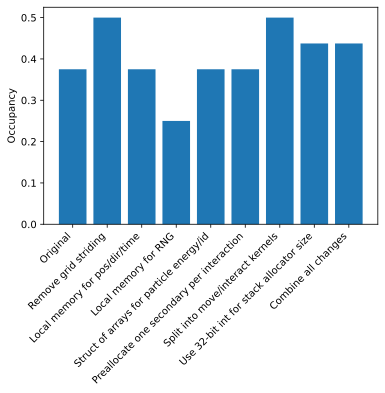

In [99]:
(fig, ax) = plt.subplots()
olabels = [labels[k] for k in results]
x_ = np.arange(len(olabels))
ax.bar(x_, occupancy)
ax.set_xticks(x_)
ax.set_xticklabels(olabels, rotation=45, ha='right')
ax.set_ylabel('Occupancy');
fig.savefig('occupancy-bar.pdf', dpi=150)

In [79]:
reg_labels = {
    'ebe3fb3': 'auto',
    'ebe3fb3-reg64': 'limit to 64 registers',
    'ebe3fb3-reg48': 'limit to 32 registers',
    'ebe3fb3-reg32': 'limit to 32 registers',
}
reg_results = {k: load_one(k) for k in reg_labels}

In [80]:
BYTES_PER_REG = 4 # 32-bit registers

q = defaultdict(list)
for r in reg_results.values():
    q['register_size'].append(r['stats']['num_regs'] * BYTES_PER_REG)
    q['occupancy'].append(r['stats']['occupancy'])
    q['spill_size'].append(r['stats']['local_mem'])
    q['time'].append(r['time'][-1])

q = {k: np.array(v) for (k,v) in q.items()}
q

{'register_size': array([272, 256, 192, 128]),
 'occupancy': array([0.375, 0.5  , 0.625, 1.   ]),
 'spill_size': array([ 48,  64, 144, 216]),
 'time': array([ 9.21409547,  9.26066117,  9.90589602, 11.73567148])}

In [81]:
(q['register_size'] + q['spill_size']) // BYTES_PER_REG

array([80, 80, 84, 86])

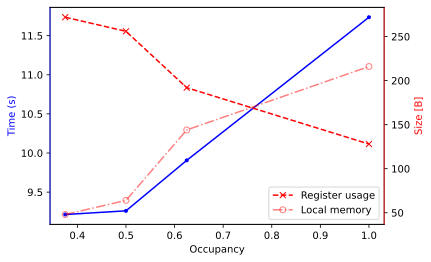

In [82]:
(fig, ax) = plt.subplots(subplot_kw=dict())
ax.plot(q['occupancy'], q['time'], 'b.-', label='Total solve time')
ax.set_xlabel("Occupancy")
ax.set_ylabel("Time (s)", color='b')
oax = ax.twinx()
oax.plot(q['occupancy'], q['register_size'], 'xr--', label="Register usage")
oax.plot(q['occupancy'], q['spill_size'], 'or-.', mfc='none', alpha=.5, label="Local memory")
oax.set_ylabel("Size [B]", color='r')
oax.legend(loc='lower right')
oax.spines['left'].set_color('b')
oax.spines['right'].set_color('r')
fig.savefig('occupancy.pdf', dpi=150);

In [100]:
!open .